We classify the fancy terms in 430 KDD 2015-2116 research papers as problem, method, and others by transfer lerning. Fancy terms in 21 papers are annotated and classified manually, and words. These annotated papers serve to train the machine to annotate automatically for the whole 430 KDD papers. First we scan the KDD database for the classified words. For each occurrence of a word in the scan, the left and right neighborhood of the word is saved. The left and right neighborhood serves as the context feature of the words, which is like an atmospherical background in which the corresponding word category is likely to shows up. Though we start with a small set of fancy words of some type, such approach enable the search for much more data context feature. Such context feature serves as the classification rule to determine the type of an unseen terminology in KDD papers.

             precision    recall  f1-score   support

    Problem       0.83      0.79      0.81      4360
     Method       0.77      0.82      0.79      3792
     Others       0.88      0.74      0.80       292

avg / total       0.81      0.80      0.80      8444



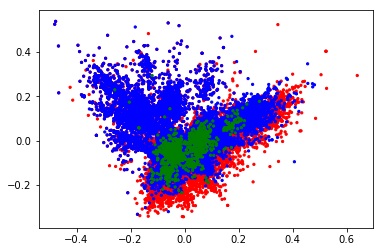

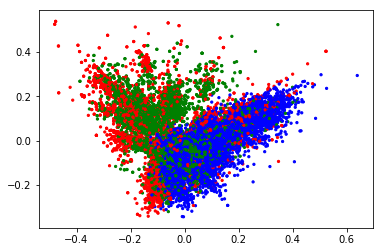

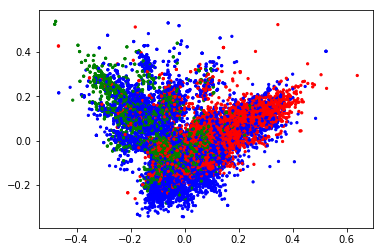

             precision    recall  f1-score   support

    Problem       0.83      0.80      0.81      4315
     Method       0.78      0.82      0.80      3845
     Others       0.89      0.73      0.80       284

avg / total       0.81      0.81      0.81      8444



In [14]:
import pandas as pd
import numpy as np
import os.path
import decimal
import nltk
import re

win=3
min_sup=0.0005
last_id=1000
ntops=3

#Import annotation data
db = pd.read_csv("Annotations.csv")
from nltk.tokenize import word_tokenize
words = set(nltk.corpus.words.words())
db["Value"]= db["Value"].apply(lambda x: word_tokenize(x.lower()))

#Extract the vocabulary for each topic
Author=list(np.unique(np.array(db[(db.Dimension=="Author")].Value)))
Problem=list(np.unique(np.array(db[(db.Dimension=="Problem")].Value)))
Method=list(np.unique(np. array(db[(db.Dimension=="Method")].Value)))
Dataset=list(np.unique(np.array(db[(db.Dimension=="Dataset")].Value)))
Metric=list(np.unique(np.array(db[(db.Dimension=="Metric")].Value)))
Method=Method+Metric
Others=Author+Dataset

#Topics considered
Topics=[Problem,Method,Others][0:ntops]
Tops=["Problem","Method","Others"][0:ntops]

L,R,L_nbh,R_nbh,nbh=({i:[] for i in range(0,len(Topics))} for j in range(5))
C_total={i:[] for i in range(-win,win+1)}
response={"label":[]}

#Context extraction. Input: item, text.Output: words in the nbh of the item in the text within win.
def context(item, text):
    n=len(item)
    C_tmp={}
    index=[i for i,x in enumerate(text) if (" ".join(text[i:i+n])==" ".join(item))&(win<=i)&(i<=len(text)-n-win) ]
    C_tmp[0]=[" ".join(item) for i in index]
    for j in range(1,win+1):
        C_tmp[-j]=[text[i-j] for i in index]  
        C_tmp[j]=[text[i+(n-1)+j] for i in index]
    return C_tmp

#Similarity measure. Input: list1, list2.Output: Jaccard, Kulczynski similarity.
def sim(list1,list2):
    set1,set2=set(list1),set(list2)
    Jaccard=len(set1&set2)/len(set1|set2)
    Kulc=(len(set1&set2)/len(set1)+len(set1&set2)/len(set2))/2
    return Jaccard, Kulc

#Scan the KDD paper dataset for the context features.
for key, T in enumerate(Topics):
    print("Topic: ", Tops[key])
    C={i:[] for i in range(-win,win+1)}
    amt=0
    for year in [15,16]:
        for num in range(last_id):
            paper="kdd"+str(year)+"-p"+str(num)+".txt"
            if os.path.isfile(paper):
                f = open (paper, "r", encoding='utf8') 
                text=re.sub("[^a-zA-Z]", " ",f.read())
                text=word_tokenize(text.lower())
                f.close()
                print(paper)
                for item in T:
                    C_tmp= context(item, text)
                    for i in range(-win,win+1): C[i].extend(C_tmp[i])
                amt+=1
                
    for i in range(-win,win+1): C_total[i].extend(C[i])
    for i in range(0,len(C[0])): response["label"].append(key)
        
    for i in range(1,win+1):
        L[key].extend(C[i])
        R[key].extend(C[-i])    
        
    L_nbh[key]=list(set([x for x in set(L[key]) if L[key].count(x)/len(C[0])>min_sup]))
    R_nbh[key]=list(set([x for x in set(R[key]) if R[key].count(x)/len(C[0])>min_sup]))
    nbh[key]=list(set(L_nbh[key])|set(R_nbh[key]))
    
    #Analysis the context features.
    Jaccard, Kulc = sim(L_nbh[key],R_nbh[key])
    print("Papers: ",amt,", L_nbh: ",len(L_nbh[key]),", R_nbh: ",len(R_nbh[key]),", Jaccard: ",round(Jaccard,3),", Kulc: ", round(Kulc,3))
    print("")

    
#Constructing the dataframe on the left.
bow={(key,i):Tops[key][0]+"_"+L_nbh[key][i] for key in range(0,len(Topics)) for i in range(0,len(L_nbh[key]))}
dataL={bow[(key,i)]:[]  for key in range(0,len(Topics)) for i in range(0,len(L_nbh[key]))}

for a in range(0,len(C_total[0])):
    segment=[]
    for b in range(-win,win+1): segment.append(C_total[b][a])
        
    for key in range(0,len(Topics)): 
        for i in range(0,len(L_nbh[key])):
            if L_nbh[key][i] in segment:
                dataL[bow[(key,i)]].append(1)                    
            else:
                dataL[bow[(key,i)]].append(0)

#Constructing the dataframe on the right.
bow={(key,i):Tops[key][0]+"_"+R_nbh[key][i] for key in range(0,len(Topics)) for i in range(0,len(R_nbh[key]))}
dataR={bow[(key,i)]:[]  for key in range(0,len(Topics)) for i in range(0,len(R_nbh[key]))}

for a in range(0,len(C_total[0])):
    segment=[]
    for b in range(-win,win+1): segment.append(C_total[b][a])
        
    for key in range(0,len(Topics)): 
        for i in range(0,len(R_nbh[key])):
            if R_nbh[key][i] in segment:
                dataR[bow[(key,i)]].append(1)                    
            else:
                dataR[bow[(key,i)]].append(0)
                
XL=np.array(pd.DataFrame(dataL))
XR=np.array(pd.DataFrame(dataR))
del(Author, Problem, Method, Dataset, Metric, Others, Topics, L,R,L_nbh,R_nbh,nbh,C_total,C_tmp,C,bow,dataL,dataR)

X=np.concatenate((XL, XR), axis=1)
y=np.array(pd.Series(response["label"]))
del (XL,XR)



#PCA
import sklearn
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
Tfidf = TfidfTransformer()
Xt=Tfidf.fit_transform(X).toarray()
pca=PCA(n_components=250)
pca.fit(Xt)
Xpca=pca.transform(Xt)
del (Xt)



#Classification by SVM
from sklearn import svm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(Xpca,y, test_size=0.25)
clf = svm.SVC(kernel="linear").fit(X_train, y_train)
y_pred=clf.predict(X_test)
#Show the classification results
from sklearn import metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names = Tops))
del (X_train, X_test, y_train, y_test)



#Gaussian Mixture model
from sklearn.mixture import GaussianMixture
gmm=GaussianMixture(n_components=ntops,n_init=30).fit(Xpca)
y_gmm=pd.Series(gmm.predict(Xpca))
#Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation
idx=(X.sum(axis=0)<=np.percentile(X.sum(axis=0), 25))
lda = LatentDirichletAllocation(n_topics=ntops,learning_method='batch').fit(X)
y_lda = lda.transform(X)
y_lda =np.argmax(y_lda,axis=1)
#Show the clustering results
import matplotlib
import matplotlib.pyplot as plt
colors =  ["red","blue","green","yellow"][0:ntops]
plt.scatter(Xpca[:,0].tolist(), Xpca[:,1].tolist(), c=y.tolist(), cmap=matplotlib.colors.ListedColormap(colors),s=5)
plt.show()
plt.scatter(Xpca[:,0].tolist(), Xpca[:,1].tolist(), c=y_gmm.tolist(), cmap=matplotlib.colors.ListedColormap(colors),s=5)
plt.show()
plt.scatter(Xpca[:,0].tolist(), Xpca[:,1].tolist(), c=y_lda.tolist(), cmap=matplotlib.colors.ListedColormap(colors),s=5)
plt.show()
label_gmm=y_gmm[:,None]
label_lda=y_lda[:,None]



#Classification by SVM with Incorporation of the clusting result
Xt=np.concatenate((Xpca, label_gmm,label_lda), axis=1)
pca.fit(Xt)
Xt=pca.transform(Xt)
X_train, X_test, y_train, y_test=train_test_split(Xt,y, test_size=0.25)
clf = svm.SVC(kernel="linear").fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = Tops))
del (Xt,X_train, X_test, y_train, y_test)